In [14]:
import numpy as np
from epyt import epanet

from esc.water_usage import MINUTES_PER_DAY, TYPICAL_BUILDING_MEAN_WATER_CONSUMPTION_LITER_PER_MINUTE, relative_occupant_water_demand
from esc.electricity_rates import electricity_rate

In [15]:
d = epanet("../networks/BUILDING.inp")

EPANET version 20200 loaded (EPyT version 1.0.1).
Input File BUILDING.inp loaded successfully.



In [16]:
SIMULATION_DURATION_S = 172800
SIMULATION_TIMESTEP_S = 60
N_SIMULATION_STEPS = SIMULATION_DURATION_S / SIMULATION_TIMESTEP_S

d.setTimeSimulationDuration(SIMULATION_DURATION_S) # 48 hour duration
d.setTimeHydraulicStep(SIMULATION_TIMESTEP_S) # Time step every minute
d.setTimePatternStep(SIMULATION_TIMESTEP_S) # Pattern step every minute

In [17]:
# Add time-dependent pattern for occupant demand to the outflow junction
# Sample the demand for every minute of the day
demand_sample_24h = relative_occupant_water_demand(np.arange(N_SIMULATION_STEPS))
d.addPattern("relative_occupant_demand", demand_sample_24h)
d.setNodeJunctionData(1, 0, TYPICAL_BUILDING_MEAN_WATER_CONSUMPTION_LITER_PER_MINUTE, 'relative_occupant_demand')

In [18]:
d.deleteControls()
tankID = 'T1'
pumpID = 'PUMP'

tankIndex = d.getNodeIndex(tankID)
pumpIndex = d.getLinkIndex(pumpID)
tankElevation = d.getNodeElevations(tankIndex)

# Hydraulic analysis STEP-BY-STEP.
d.openHydraulicAnalysis()
d.initializeHydraulicAnalysis(0)

tstep = 1
i = 0
T, P, F, S, E = [], [], [], [], []

# CONTROLS.
Below = 0.07
Above = 0.08
tankHead = []
while tstep > 0:

    H = d.getNodeHydraulicHead()
    tankHead.append(H[tankIndex - 1] - tankElevation)

    # Add new controls in live.
    # Turn on the pump if electricity is cheap
    if electricity_rate(i) < Below:
        d.setLinkStatus(pumpIndex, 1)
    # Turn off the pump if electricity is expensive
    if electricity_rate(i) > Above:
        d.setLinkStatus(pumpIndex, 0)
    i += 1

    t = d.runHydraulicAnalysis()

    S.append(d.getLinkStatus(pumpIndex))
    F.append(d.getLinkFlows())
    P.append(d.getNodePressure())
    E.append(d.getLinkEnergy(pumpIndex))
    T.append(t)

    tstep = d.nextHydraulicAnalysisStep()

d.closeHydraulicAnalysis()
print("Hydraulic Analysis completed succesfully.")

Hydraulic Analysis completed succesfully.


/opt/homebrew/Caskroom/mambaforge/base/envs/engineering-smart-cities/lib/python3.10/site-packages/epyt/epanet.py:11948: UserWarning: WARNING: System has negative pressures.
  warnings.warn(errmssg.value.decode())


/opt/homebrew/Caskroom/mambaforge/base/envs/engineering-smart-cities/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


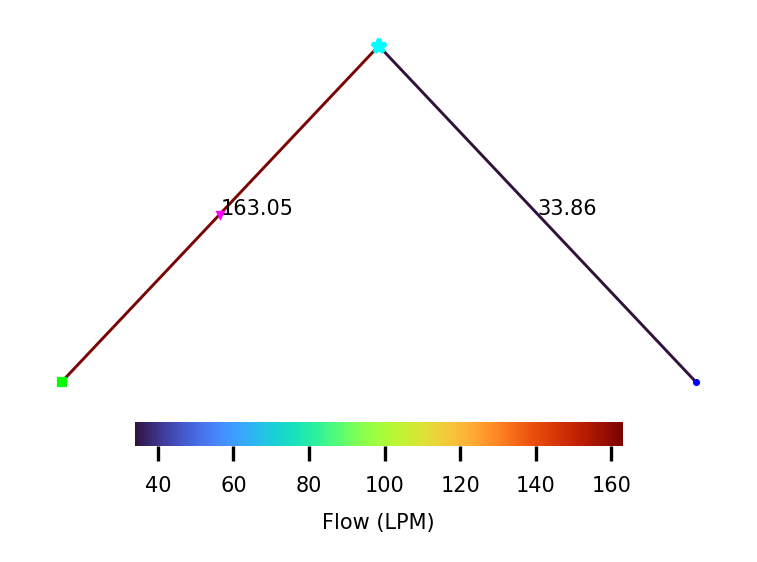

In [19]:
_ = d.plot(flow=F[48], flow_text=True)

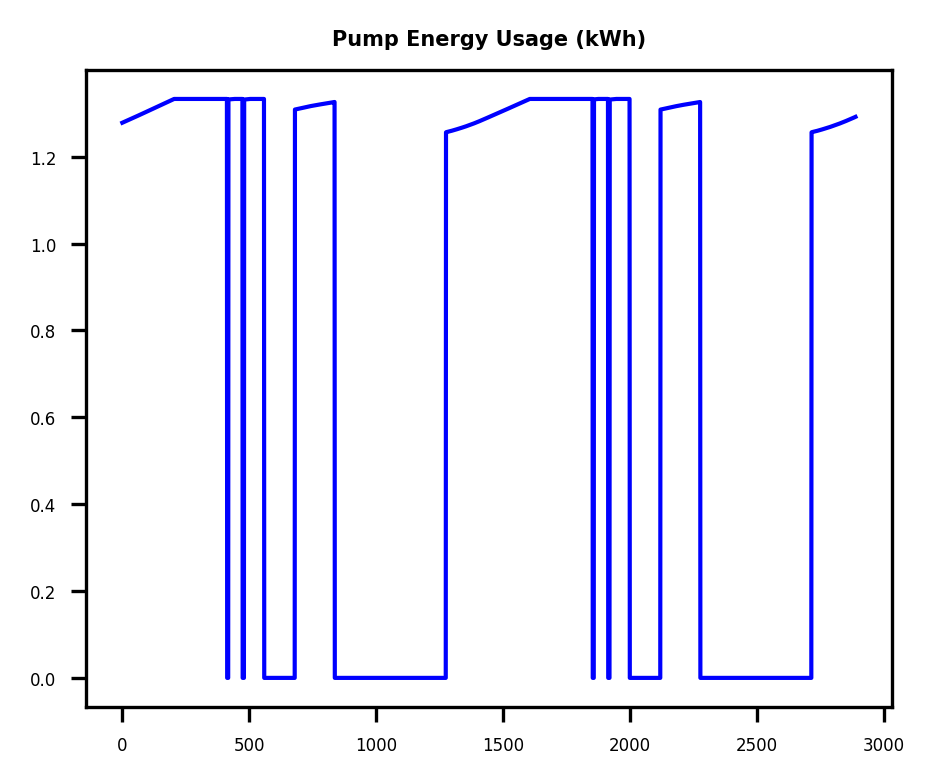

In [20]:
d.plot_ts(Y=E, title="Pump Energy Usage (kWh)", marker=False)

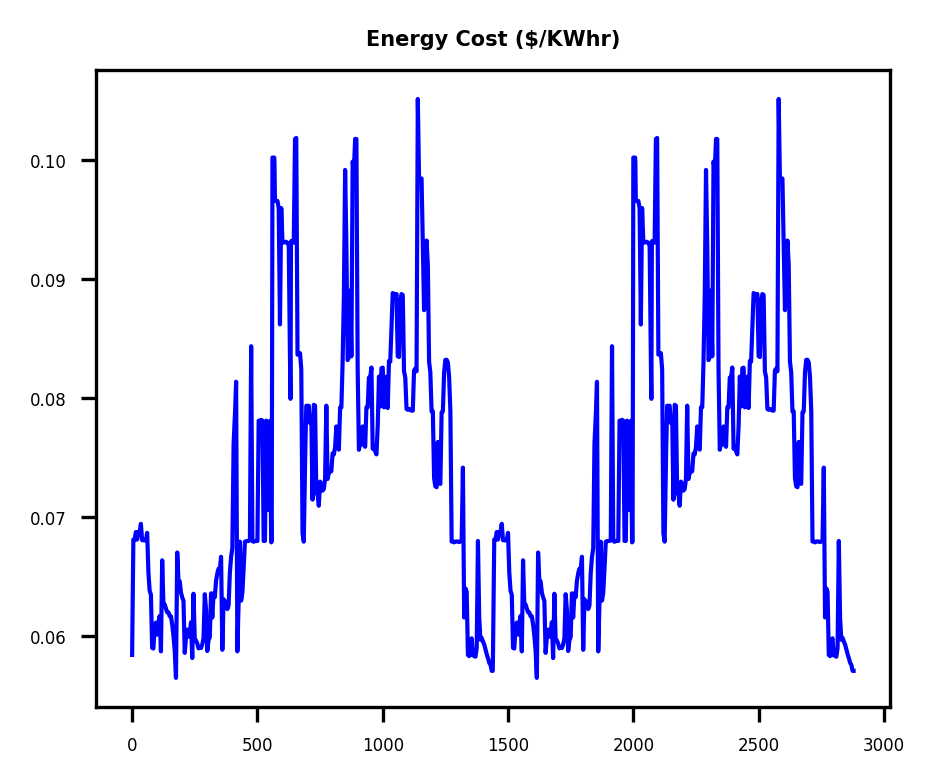

In [21]:
d.plot_ts(Y=electricity_rate(np.arange(N_SIMULATION_STEPS)), title="Energy Cost ($/KWhr)", marker=False)

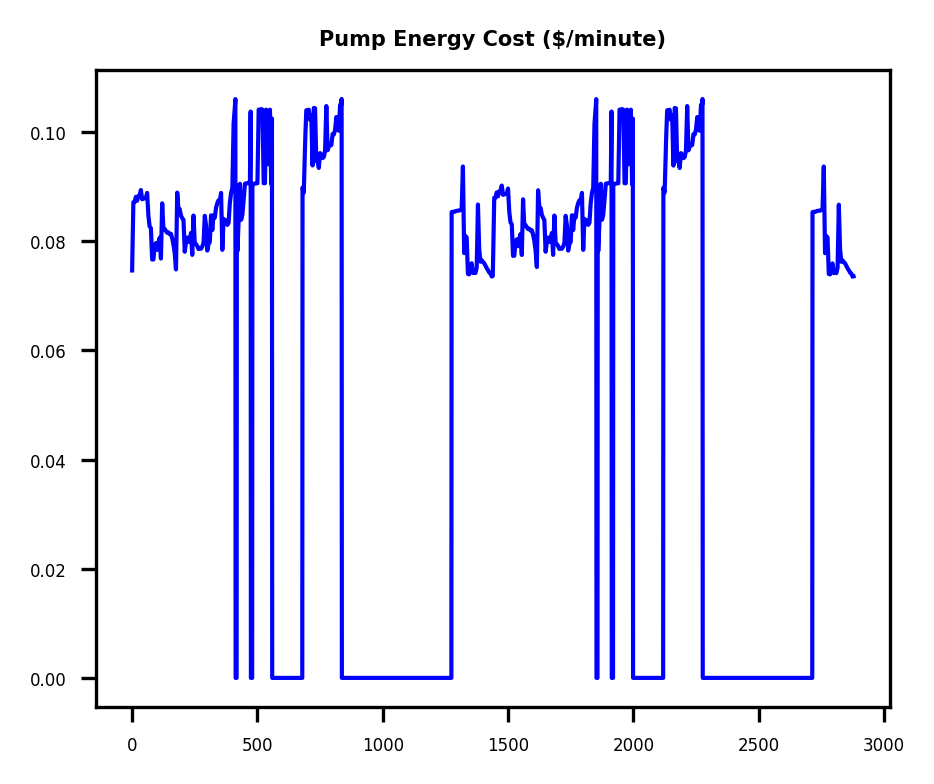

In [22]:
d.plot_ts(Y=np.array(E[:-9]) * electricity_rate(np.arange(N_SIMULATION_STEPS)), title="Pump Energy Cost ($/minute)", marker=False)

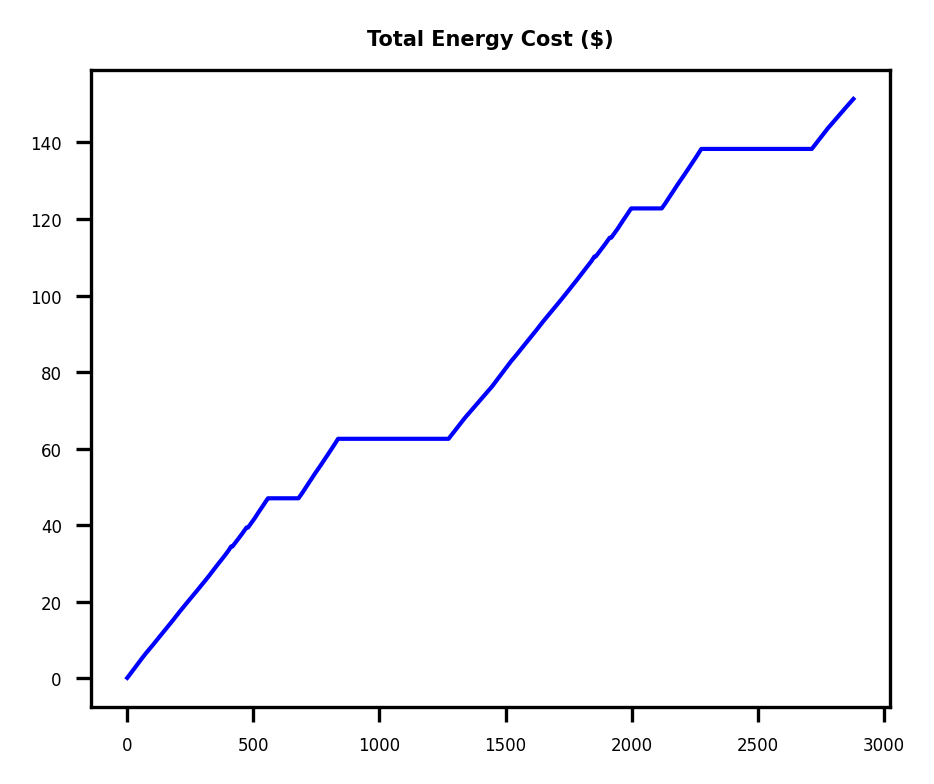

In [23]:
d.plot_ts(Y=np.cumsum(np.array(E[:-9]) * electricity_rate(np.arange(N_SIMULATION_STEPS))), title="Total Energy Cost ($)", marker=False)

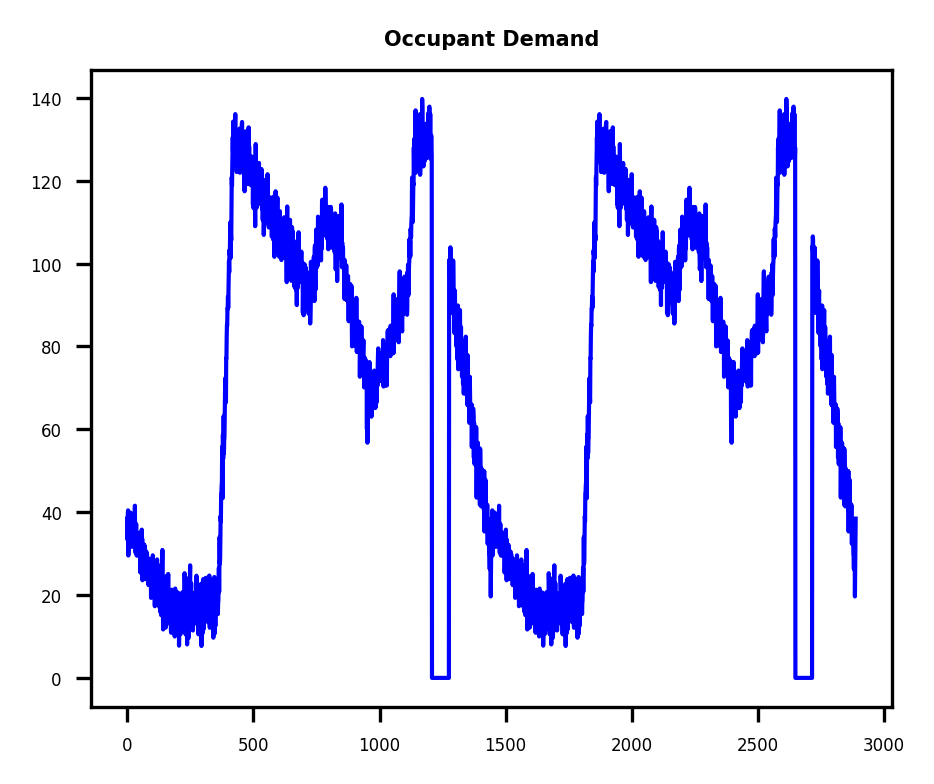

In [24]:
d.plot_ts(Y=np.array(F)[:, 0], title="Occupant Demand", marker=False)

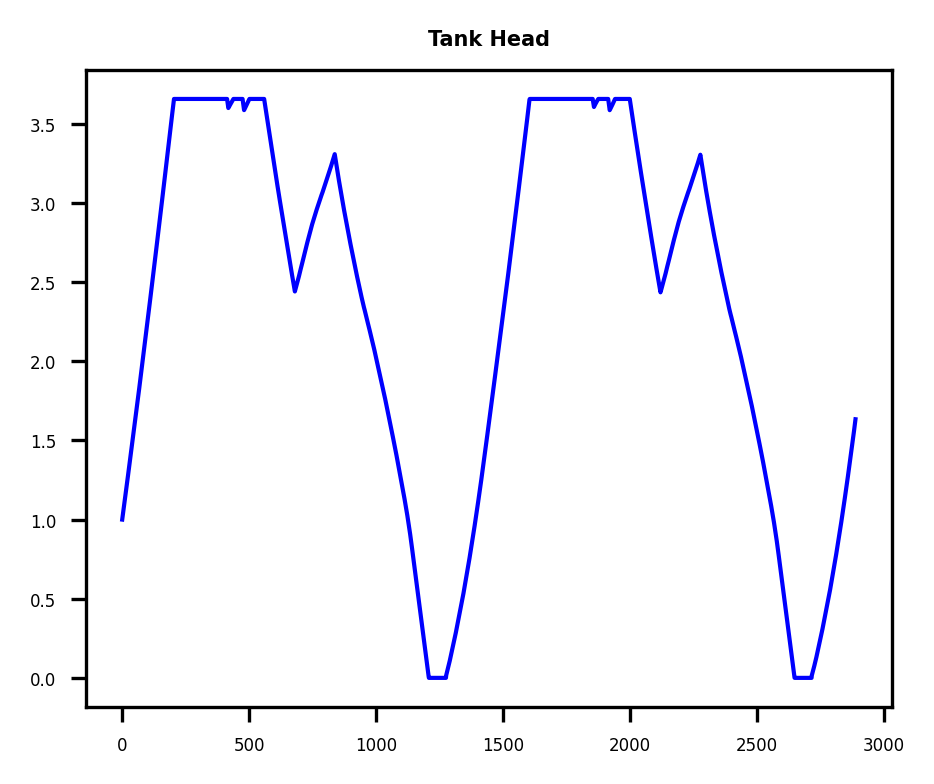

In [25]:
d.plot_ts(Y=tankHead, title='Tank Head', marker=False)